/var/folders/pz/p1hrncws1n5gsmzgxczt0rpm0000gn/T/ipykernel_9455/22056319.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = df_train.groupby("Binary_Engagement", group_keys=False).apply(


Before balancing: Counter({1: 4651, 0: 231})
After balancing : Counter({0: 3720, 1: 3720})

===== XGBOOST K-FOLD =====

---- Fold 1 ----
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       1.00      0.99      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [  8 736]]

---- Fold 2 ----
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       1.00      0.99      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [ 11 733]]

---- Fold 3 ----
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       744
           1      

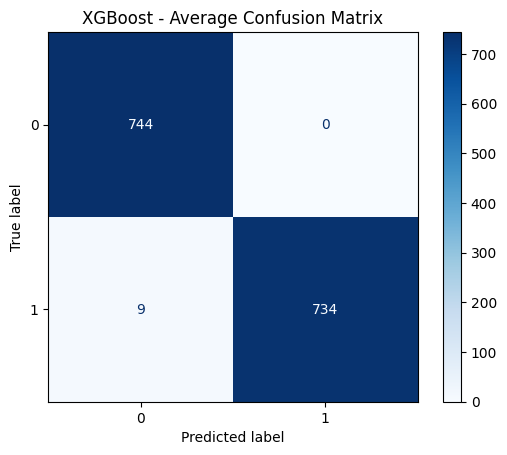


===== K-FOLD AVERAGE METRICS =====
Accuracy  : 0.993
Precision : 1.000
Recall    : 0.987
F1 Score  : 0.993

===== VALIDATION PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.28      0.22      0.24        23
           1       0.96      0.97      0.97       465

    accuracy                           0.94       488
   macro avg       0.62      0.59      0.61       488
weighted avg       0.93      0.94      0.93       488

[[  5  18]
 [ 13 452]]


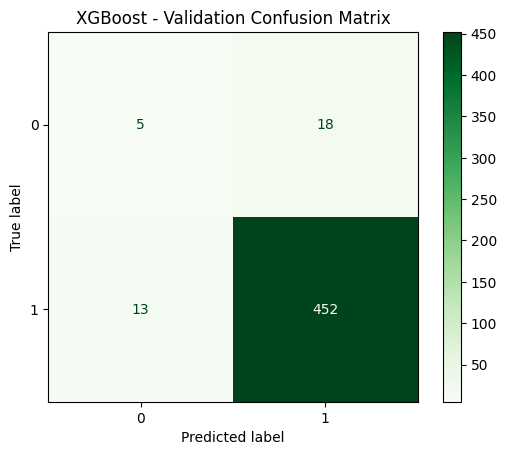

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from collections import Counter
import xgboost as xgb

# -----------------------------
# Load dataset
# -----------------------------
data = pd.read_csv("/Users/khushnumaparveen/Downloads/merged_results.csv")

# -----------------------------
# Select features
# -----------------------------
au_cols = [col for col in data.columns if col.startswith("au")]
landmark_cols = [col for col in data.columns if col.startswith("x_") or col.startswith("y_")]

possible_pose_cols = ["pose_Rx", "pose_Ry", "pose_Rz", "pitch", "yaw", "roll"]
pose_cols = [col for col in possible_pose_cols if col in data.columns]

feature_cols = au_cols + landmark_cols + pose_cols
X = data[feature_cols].fillna(0)

# -----------------------------
# Convert Engagement → Binary
# 1 = engaged (>=2)
# 0 = disengaged (<=1)
# -----------------------------
data["Binary_Engagement"] = (data["Engagement"] >= 2).astype(int)
y = data["Binary_Engagement"]

# -----------------------------
# Train / Validation / Test Split (80/10/10)
# -----------------------------
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# -----------------------------
# Balance ONLY the training set
# -----------------------------
df_train = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train["Binary_Engagement"].value_counts().max()

balanced_train = df_train.groupby("Binary_Engagement", group_keys=False).apply(
    lambda x: x.sample(max_size, replace=True, random_state=42)
).reset_index(drop=True)

X_bal = balanced_train[feature_cols]
y_bal = balanced_train["Binary_Engagement"]

print("Before balancing:", Counter(y))
print("After balancing :", Counter(y_bal))

# -----------------------------
# Scale Features
# -----------------------------
scaler = StandardScaler()
X_bal_scaled     = scaler.fit_transform(X_bal)
X_val_scaled     = scaler.transform(X_val)
X_test_scaled    = scaler.transform(X_test)

# -----------------------------
# XGBoost Model Definition
# -----------------------------
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200, #Best Params: (0.2, 8, 200, 0.7, 0.8, 0.0, 0.0)
    max_depth=8,
    learning_rate=0.2,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=0.0,
    reg_alpha=0.0,
    scale_pos_weight=1,
    n_jobs=-1,
    random_state=42
)

# -----------------------------
# 5-FOLD CROSS VALIDATION
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s = [], [], [], []
all_cm = np.zeros((2,2), dtype=int)

print("\n===== XGBOOST K-FOLD =====")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_bal_scaled, y_bal), 1):
    X_train, X_test_fold = X_bal_scaled[train_idx], X_bal_scaled[test_idx]
    y_train, y_test_fold = y_bal.iloc[train_idx], y_bal.iloc[test_idx]

    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict(X_test_fold)

    accs.append(accuracy_score(y_test_fold, pred))
    precs.append(precision_score(y_test_fold, pred, zero_division=0))
    recs.append(recall_score(y_test_fold, pred, zero_division=0))
    f1s.append(f1_score(y_test_fold, pred, zero_division=0))

    cm = confusion_matrix(y_test_fold, pred)
    all_cm += cm

    print(f"\n---- Fold {fold} ----")
    print(classification_report(y_test_fold, pred))
    print(cm)

# -----------------------------
# Average Confusion Matrix
# -----------------------------
avg_cm = all_cm // skf.get_n_splits()
print("\n===== AVERAGE CONFUSION MATRIX =====")
print(avg_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("XGBoost - Average Confusion Matrix")
plt.show()

print("\n===== K-FOLD AVERAGE METRICS =====")
print(f"Accuracy  : {np.mean(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f}")
print(f"F1 Score  : {np.mean(f1s):.3f}")

# -----------------------------
# Train Final Model
# -----------------------------
final_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200, #Best Params: (0.2, 8, 200, 0.7, 0.8, 0.0, 0.0)
    max_depth=8,
    learning_rate=0.2,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=0.0,
    reg_alpha=0.0,
    scale_pos_weight=1,
    n_jobs=-1,
    random_state=42
)

final_xgb.fit(X_bal_scaled, y_bal)

# -----------------------------
# Validation Performance
# -----------------------------
val_pred = final_xgb.predict(X_val_scaled)

print("\n===== VALIDATION PERFORMANCE =====")
print(classification_report(y_val, val_pred))

val_cm = confusion_matrix(y_val, val_pred)
print(val_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=[0,1])
disp.plot(cmap="Greens")
plt.title("XGBoost - Validation Confusion Matrix")
plt.show()




In [12]:
# from sklearn.metrics import f1_score
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# import xgboost as xgb

# # ----------------------------
# # PARAMETER GRID (editable)
# # ----------------------------
# learning_rates = [0.05, 0.1, 0.2]
# max_depths     = [4, 6, 8, 10]
# n_estimators   = [200, 300, 400]
# subsamples     = [0.7, 0.8, 1.0]
# colsample_bt   = [0.7, 0.8, 1.0]
# reg_lambdas    = [0.0, 1.0]
# reg_alphas     = [0.0, 0.5]

# # ----------------------------
# # TUNING LOOP
# # ----------------------------
# best_score = -1
# best_params = None

# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# print("\n===== XGBOOST Hyperparameter Tuning Started =====\n")

# for lr in learning_rates:
#     for md in max_depths:
#         for ne in n_estimators:
#             for ss in subsamples:
#                 for cs in colsample_bt:
#                     for rl in reg_lambdas:
#                         for ra in reg_alphas:

#                             fold_scores = []

#                             for train_idx, val_idx in skf.split(X_bal_scaled, y_bal):
#                                 X_tr, X_va = X_bal_scaled[train_idx], X_bal_scaled[val_idx]
#                                 y_tr, y_va = y_bal.iloc[train_idx], y_bal.iloc[val_idx]

#                                 model = xgb.XGBClassifier(
#                                     objective="binary:logistic",
#                                     eval_metric="logloss",
#                                     n_estimators=ne,
#                                     max_depth=md,
#                                     learning_rate=lr,
#                                     subsample=ss,
#                                     colsample_bytree=cs,
#                                     reg_lambda=rl,
#                                     reg_alpha=ra,
#                                     scale_pos_weight=1,  # already balanced
#                                     n_jobs=-1,
#                                     random_state=42
#                                 )

#                                 model.fit(X_tr, y_tr)
#                                 preds = model.predict(X_va)

#                                 score = f1_score(y_va, preds, zero_division=0)
#                                 fold_scores.append(score)

#                             avg_score = np.mean(fold_scores)

#                             print(f"Params: lr={lr}, depth={md}, est={ne}, "
#                                   f"subsample={ss}, col={cs}, reg_l={rl}, reg_a={ra} --> F1={avg_score:.4f}")

#                             if avg_score > best_score:
#                                 best_score = avg_score
#                                 best_params = (lr, md, ne, ss, cs, rl, ra)

# print("\n===== BEST XGBOOST PARAMETERS FOUND =====")
# print("Best F1 Score:", best_score)
# print("Best Params:", best_params)



===== XGBOOST Hyperparameter Tuning Started =====

Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.7, reg_l=0.0, reg_a=0.0 --> F1=0.9691
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.7, reg_l=0.0, reg_a=0.5 --> F1=0.9669
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.7, reg_l=1.0, reg_a=0.0 --> F1=0.9597
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.7, reg_l=1.0, reg_a=0.5 --> F1=0.9613
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.8, reg_l=0.0, reg_a=0.0 --> F1=0.9687
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.8, reg_l=0.0, reg_a=0.5 --> F1=0.9659
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.8, reg_l=1.0, reg_a=0.0 --> F1=0.9617
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=0.8, reg_l=1.0, reg_a=0.5 --> F1=0.9616
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=1.0, reg_l=0.0, reg_a=0.0 --> F1=0.9654
Params: lr=0.05, depth=4, est=200, subsample=0.7, col=1.0, reg_l=0.0, reg_a=0.5 --> F1=0.9645
Params: 


===== TEST PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.21      0.17      0.19        23
           1       0.96      0.97      0.96       466

    accuracy                           0.93       489
   macro avg       0.59      0.57      0.58       489
weighted avg       0.92      0.93      0.93       489

[[  4  19]
 [ 15 451]]


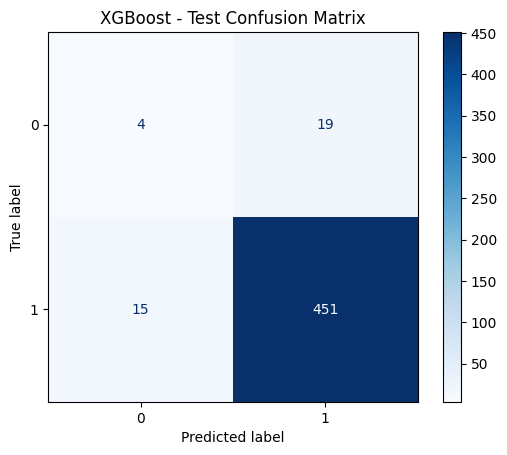

In [4]:
# -----------------------------
# Test Performance
# -----------------------------
test_pred = final_xgb.predict(X_test_scaled)

print("\n===== TEST PERFORMANCE =====")
print(classification_report(y_test, test_pred))

test_cm = confusion_matrix(y_test, test_pred)
print(test_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("XGBoost - Test Confusion Matrix")
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix

def accuracy_details(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc_class_0 = tn / (tn + fn + 1e-9)
    acc_class_1 = tp / (tp + fp + 1e-9)
    overall_acc = (tp + tn) / (tp + tn + fp + fn)

    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Class 0 (Disengaged): {acc_class_0:.3f}")
    print(f"Accuracy Class 1 (Engaged)   : {acc_class_1:.3f}")
    print(f"Overall Accuracy             : {overall_acc:.3f}")

accuracy_details(y_test,test_pred)

Confusion Matrix:
 [[  4  19]
 [ 15 451]]

Accuracy Class 0 (Disengaged): 0.211
Accuracy Class 1 (Engaged)   : 0.960
Overall Accuracy             : 0.930


In [3]:
import pickle

# Save the final model
with open("final_xgb_model.pkl", "wb") as file:
    pickle.dump(final_xgb, file)

print("Model saved as final_xgb_model.pkl")


NameError: name 'final_xgb' is not defined